In [8]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os

os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

In [10]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 767M/778M [00:05<00:00, 166MB/s]
100% 778M/778M [00:05<00:00, 159MB/s]


In [11]:
!unzip -q "/content/covid19-radiography-database.zip"

In [12]:
import imageio
import numpy as np
import PIL

import seaborn as sns

from skimage import color
from skimage import io

import sklearn
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [13]:
root_folder = '/content/COVID-19_Radiography_Dataset/'

# Display image
nparray = np.array(PIL.Image.open(root_folder + 'COVID/images/COVID-1.png'))
print(nparray.shape)

img = io.imread(root_folder + 'COVID/images/COVID-1.png')
print(img.shape)
print(type(img))

(299, 299)
(299, 299)
<class 'numpy.ndarray'>


In [14]:
from skimage.util import img_as_int
def load_dataset(path, n_images, resolution):
    """
    Args:
        path: path to the dataset
        n_images: number of images to load
    Return:
        dataset: a list of numpy arrays containing the images
    """
    dataset = []
    # Read all images in the folder
    for filename in os.listdir(path+'images/')[:n_images]:
        # Read image with numpy
        image_as_np = io.imread(path + 'images/' + filename, as_gray=True)
        # print(image_as_np.dtype)
        mask_as_np = io.imread(path + 'masks/' + filename, as_gray=True)
        # print(mask_as_np.dtype)
        # Scale image to 255 to convert it to dtype unit8 from float64
        mask_as_np = 255 * mask_as_np
        mask_as_np = mask_as_np.astype(np.uint8) 
  
        mask_as_np = resize(mask_as_np, (resolution, resolution), anti_aliasing=True)
        image_as_np = resize(image_as_np, (resolution, resolution), anti_aliasing=True)
  
        im_mask_as_np = (image_as_np * (mask_as_np != 0))
        # Add image to the dataset
        dataset.append(im_mask_as_np)

    return dataset

[0.50550245 0.60445833 0.60239461 ... 0.86901902 0.89243147 0.87913637]


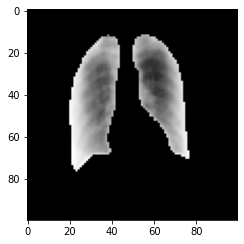

In [15]:
from matplotlib import pyplot as plt 

plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True 

data = load_dataset(root_folder + 'COVID/', 1, 100)[0]

print(data[np.where(data != 0)])

plt.imshow(data, cmap='gray') 
plt.show()

In [16]:
root_folder = '/content/COVID-19_Radiography_Dataset/'

N_IMAGES = 1000
# Resize images to 10x10
RESOLUTION = 64
covid_images = load_dataset(root_folder + 'COVID/', N_IMAGES, RESOLUTION)
lung_opacity_images = load_dataset(root_folder + 'Lung_Opacity/', N_IMAGES, RESOLUTION)
normal_images = load_dataset(root_folder + 'Normal/', N_IMAGES, RESOLUTION)
viral_images = load_dataset(root_folder + 'Viral Pneumonia/', N_IMAGES, RESOLUTION)


# covid_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in covid_images]
# lung_opacity_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in lung_opacity_images]
# normal_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in normal_images]
# viral_images = [resize(image, (RESOLUTION, RESOLUTION), anti_aliasing=True) for image in viral_images]

print(covid_images[0].shape, lung_opacity_images[0].shape, normal_images[0].shape, viral_images[0].shape)

# Flatten images
covid_images = [image.flatten() for image in covid_images]
lung_opacity_images = [image.flatten() for image in lung_opacity_images]
normal_images = [image.flatten() for image in normal_images]
viral_images = [image.flatten() for image in viral_images]

print(covid_images[0].shape, lung_opacity_images[0].shape, normal_images[0].shape, viral_images[0].shape)

X = np.concatenate((covid_images, lung_opacity_images, normal_images, viral_images))
print(X.shape)

(64, 64) (64, 64) (64, 64) (64, 64)
(4096,) (4096,) (4096,) (4096,)
(4000, 4096)


In [17]:
COVID_LABEL = 1
LUNG_OPACITY_LABEL = 2
NORMAL_LABEL = 3
VIRAL_LABEL = 4

labels = np.array([COVID_LABEL] * len(covid_images) + [LUNG_OPACITY_LABEL] * len(lung_opacity_images) + [NORMAL_LABEL] * len(normal_images) + [VIRAL_LABEL] * len(viral_images))

In [18]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, shuffle=True)
y_binarize_train = label_binarize(y_train, classes=[1, 2, 3, 4])
y_binarize_test = label_binarize(y_test, classes=[1, 2, 3, 4])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2800, 4096) (1200, 4096) (2800,) (1200,)


In [19]:
model_names = ["GaussianNB", "ComplementNB", "BernoulliNB", "MultinomialNB", "RandomForestClassifier", "SVC", "MLPClassifier"]

In [20]:
models = [GaussianNB(), ComplementNB(), BernoulliNB(), MultinomialNB(), RandomForestClassifier(), SVC(probability=True), MLPClassifier(learning_rate='adaptive', max_iter=300)]

In [21]:
fits = [ model.fit(X_train, y_train) for model in models ]

In [22]:
predictions = [ model.predict(X_test) for model in models ]

In [23]:
predictions_prob = [ fit.predict_proba(X_test) for fit in fits ]

In [24]:
accuracies = [ accuracy_score(y_test, prediction) for prediction in predictions ]
print(accuracies)

[0.37666666666666665, 0.5208333333333334, 0.5508333333333333, 0.5291666666666667, 0.7125, 0.6675, 0.6616666666666666]


In [25]:
roc_auc_scores = [ roc_auc_score(y_test, prediction_prob, multi_class='ovr') for prediction_prob in predictions_prob ]
print(roc_auc_scores)

[0.6185531456039566, 0.762507934520884, 0.7763184075625513, 0.7645406904188283, 0.9016392126911603, 0.878380764767195, 0.8650891672823767]


In [35]:
from sklearn.metrics import classification_report
for i, pred in enumerate(predictions):
  print(model_names[i])
  print(classification_report(y_test, pred, target_names=['COVID','LUNG_OPACITY', 'NORMAL', 'VIRAL']))

GaussianNB
              precision    recall  f1-score   support

       COVID       0.59      0.10      0.17       305
LUNG_OPACITY       0.42      0.15      0.22       288
      NORMAL       0.30      0.24      0.26       276
       VIRAL       0.38      0.95      0.54       331

    accuracy                           0.38      1200
   macro avg       0.42      0.36      0.30      1200
weighted avg       0.42      0.38      0.31      1200

ComplementNB
              precision    recall  f1-score   support

       COVID       0.43      0.30      0.36       305
LUNG_OPACITY       0.46      0.46      0.46       288
      NORMAL       0.47      0.38      0.42       276
       VIRAL       0.62      0.89      0.73       331

    accuracy                           0.52      1200
   macro avg       0.50      0.51      0.49      1200
weighted avg       0.50      0.52      0.50      1200

BernoulliNB
              precision    recall  f1-score   support

       COVID       0.44      0.34      

In [26]:
confusion_matrices = [ confusion_matrix(y_test, prediction, labels=[COVID_LABEL, LUNG_OPACITY_LABEL, NORMAL_LABEL, VIRAL_LABEL]) for prediction in predictions ]

In [27]:
def plot_confusion_matrix(confusion_matrix, title):
  sns.set(rc={"figure.figsize":(8, 8)})
  ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

  ax.set_title("Confusion Matrix for " + title);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels(['COVID','LUNG_OPACITY', 'NORMAL', 'VIRAL'])
  ax.yaxis.set_ticklabels(['COVID','LUNG_OPACITY', 'NORMAL', 'VIRAL'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

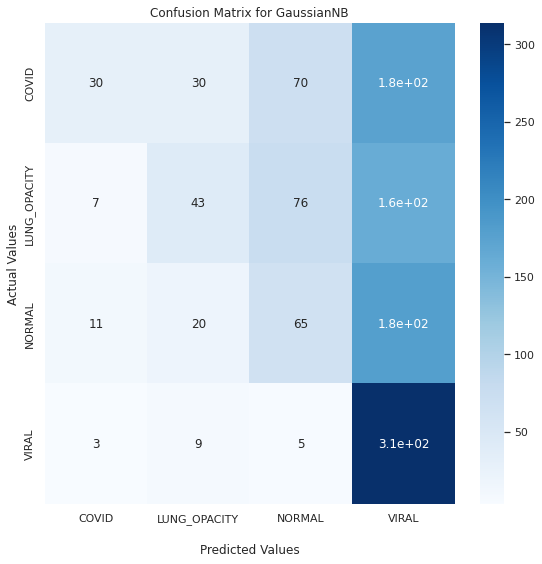

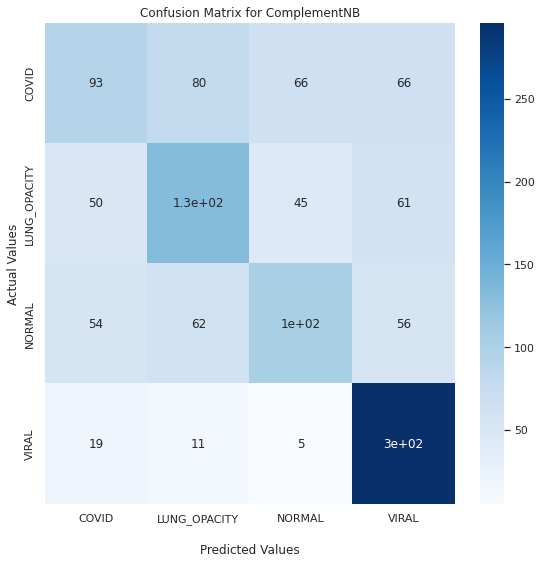

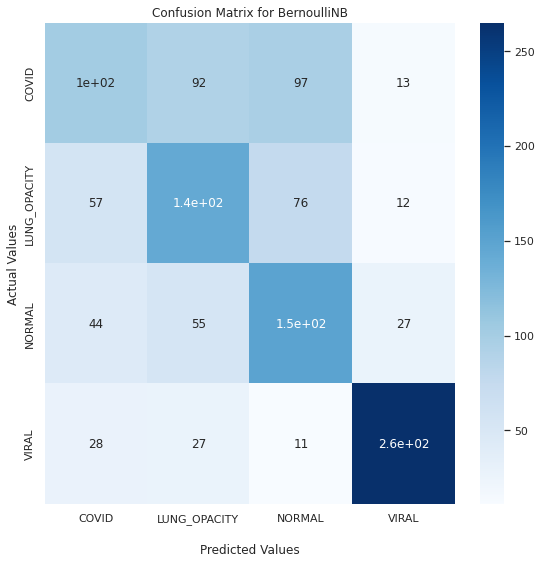

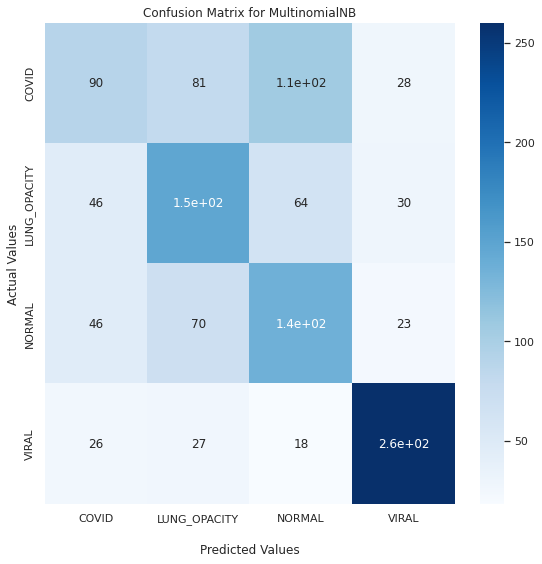

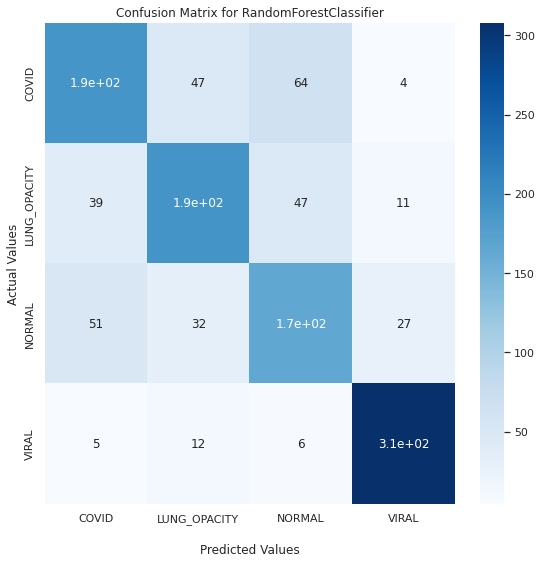

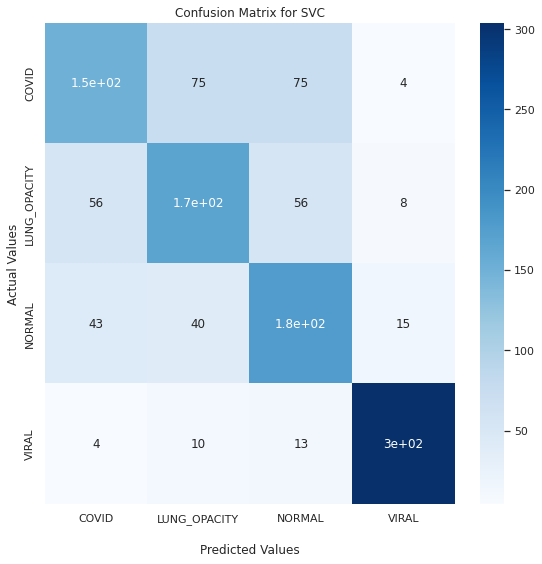

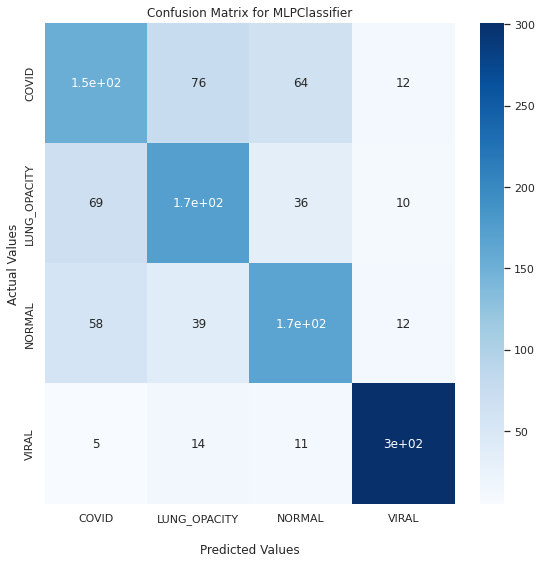

In [28]:
for i in range(len(model_names)):
  plot_confusion_matrix(confusion_matrices[i], model_names[i])

In [29]:
ovr_models = [ OneVsRestClassifier(model) for model in models ]

In [30]:
binarize_fits = [ ovr_model.fit(X_train, y_binarize_train) for ovr_model in ovr_models ]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [31]:
binarize_predictions = [ ovr_model.predict_proba(X_test) for ovr_model in ovr_models ]

In [32]:
def compute_roc_curve(test_y, predicted_y):
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(4):
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predicted_y[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predicted_y.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  return fpr, tpr, roc_auc

In [33]:
def plot_auc_roc_curves(binarize_test_y, binarize_prediction, title):
  fpr, tpr, roc_auc = compute_roc_curve(binarize_test_y, binarize_prediction)
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(4):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= 4

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=4,
  )

  for i in range(4):
      plt.plot(
          fpr[i],
          tpr[i],
          lw=2,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for " + title)
  plt.legend(loc="lower right")
  plt.show()


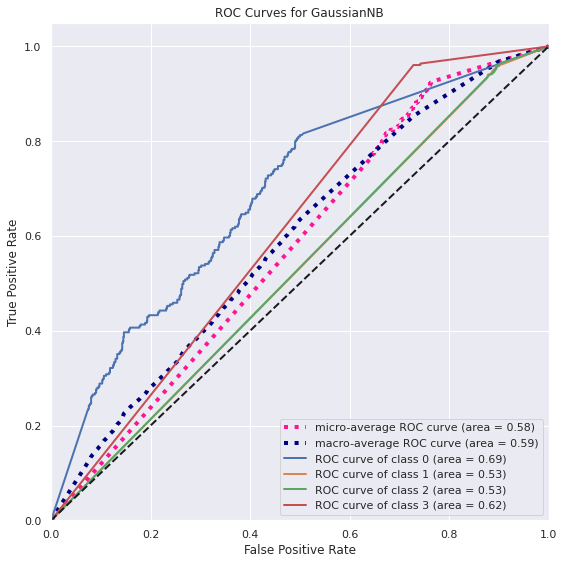

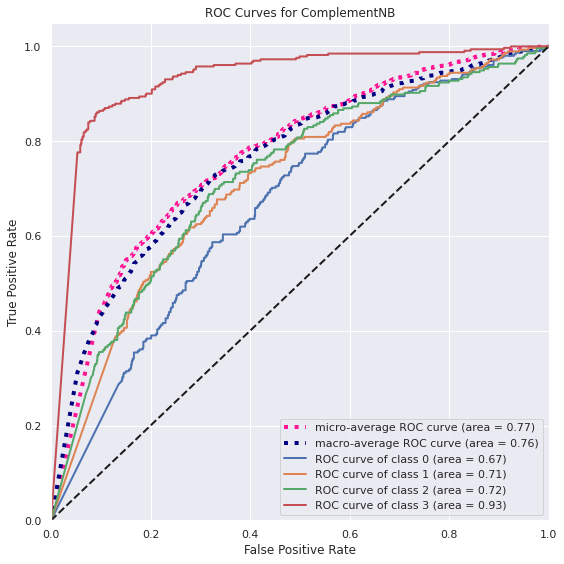

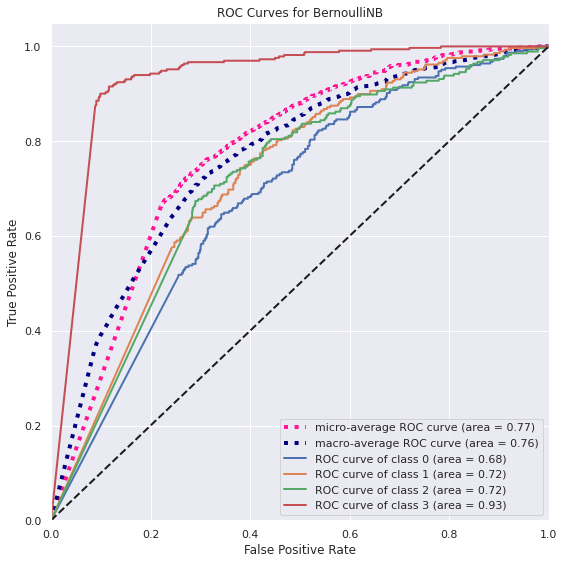

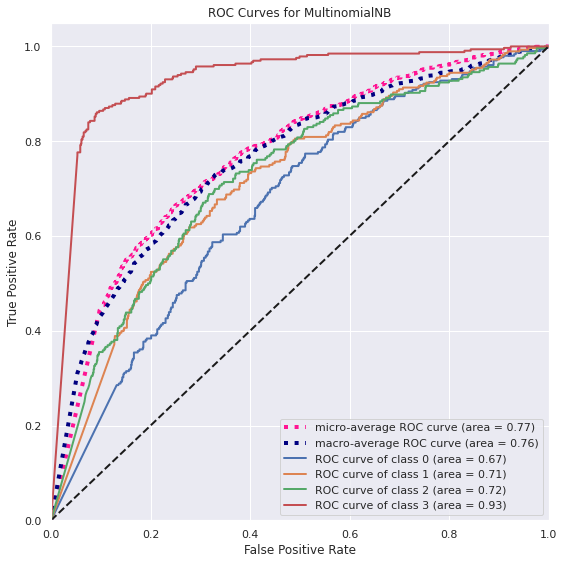

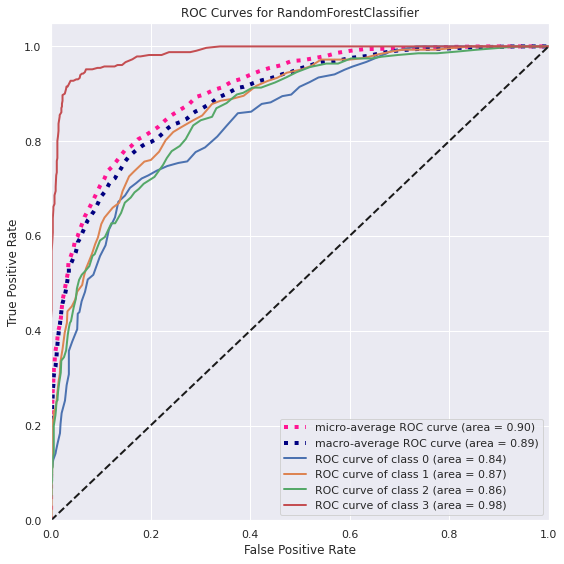

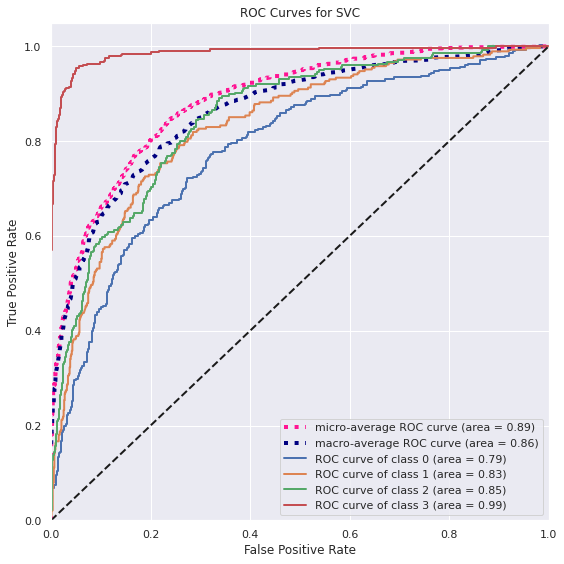

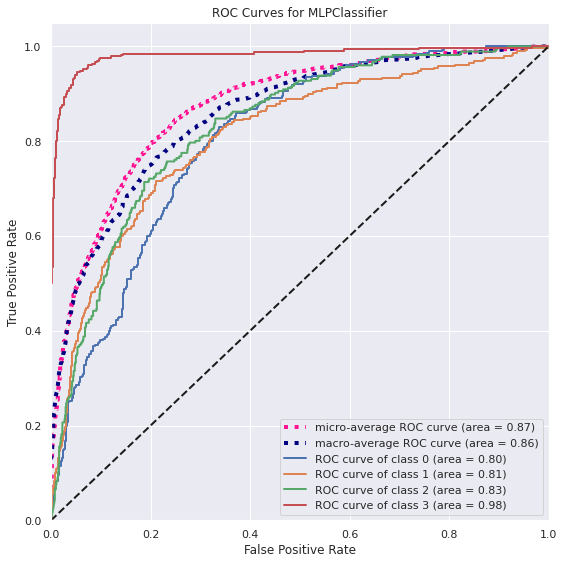

In [34]:
for i in range(len(model_names)):
  plot_auc_roc_curves(y_binarize_test, binarize_predictions[i], model_names[i])